In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from time import sleep
from PIL import Image
import seaborn as sns
sns.set_theme()

# Environment 4x4


In [2]:
class Tetris:
    '''Tetris game class'''
    
    MAP_EMPTY = 0
    MAP_BLOCK = 1
    MAP_PLAYER = 2
    BOARD_WIDTH = 4
    BOARD_HEIGHT = 4
    
    COLORS = {
        0: (211,211,211),
        1: (255,160,122),
        2: (0,0,255),
        3: (0,0,0),
        4: (0,128,0)
    }
    
    
    def __init__(self, mode = 'punish'):
        self.reset()
        self.mode = mode
        
        
    def reset(self):
        self.state = np.array([[0] * (Tetris.BOARD_WIDTH) for _ in range(Tetris.BOARD_HEIGHT)],dtype = int)
        self.total_lines = 0
        self.game_over = False
        
        return self.state.tobytes()
    
    def step(self,action, render = False):
        
        if action in [0,1,2,3]:
            self.state[0][action] +=1
            self.state[1][action] +=1
            self.check_terminal()
 
        else:
            self.state[0][action-4] +=1
            self.state[0][action-3] +=1
            self.check_terminal()
 
        if not self.game_over:
            if action in [0,1,2,3]:
                for i in range(2,4):
                    if self.state[i][action] ==0:
                        self.state[i-2][action] -=1
                        self.state[i][action] +=1
 
                    else:
 
                        break
            else:
                for i in range(1,4):
                    if self.state[i][action-4:action-2].sum() == 0:
                        self.state[i-1][action-4] -=1
                        self.state[i-1][action-3] -=1
                        self.state[i][action-4] +=1
                        self.state[i][action-3] +=1
                    else:
 
                        break
 
            self.clear_lines()
 
        if self.game_over:
            reward = -10
        elif self.lines_cleared ==0:
            if self.mode == 'punish':
                reward = -1
            elif self.mode == 'perfect':
                reward = 0
        elif self.lines_cleared ==1:
            reward =1
        elif self.lines_cleared ==2:
            reward = 4
        else:
            print("wrong")
        
        if render:
            
            self.render()
        self.state = self.state.astype(int)
        return self.state.tobytes(), reward, self.game_over
    
    
    def clear_lines(self):
        empty_lines = []
        for i in range(3,-1,-1):
            if (self.state[i]==1).all():
                empty_lines.append(i)
 
        self.lines_cleared = 0
        if empty_lines:
            self.total_lines += len(empty_lines)
            self.lines_cleared += len(empty_lines)
            for i in empty_lines:
                self.state =np.delete(self.state,i,0)
            a= np.zeros((len(empty_lines),4))
            self.state = np.vstack((a, self.state))
 
 
    def check_terminal(self):
        for i in np.unique(self.state):
            if i not in [0,1]:
                self.game_over = True
 
 
    def render(self):
        '''Renders the current board'''
 
 
        img = [Tetris.COLORS[p] for row in self.state for p in row]
        img = np.array(img).reshape(Tetris.BOARD_HEIGHT, Tetris.BOARD_WIDTH, 3).astype(np.uint8)
        img = img[..., ::-1] # Convert RRG to BGR (used by cv2)
        img = Image.fromarray(img, 'RGB')
        
        img = np.array(img)
        img=cv2.resize(img,(Tetris.BOARD_WIDTH *50, Tetris.BOARD_HEIGHT * 50),interpolation = cv2.INTER_AREA)
#         cv2.putText(img, str(self.score), (22, 22), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 1)
        cv2.imshow('image', np.array(img))
        cv2.waitKey(1)
        
    

# Random Agent

In [3]:
#visualize random agent
env = Tetris()
actions = [i for i in range(7)]
env.reset()
terminal = False
while not terminal:
    action = np.random.choice(actions)

    state,reward,terminal = env.step(action,render = True)
    sleep(0.5)


In [4]:
env = Tetris()
actions = [i for i in range(7)]
lines_cleared = []
for i in range(1000):
    env.reset()
    lines = 0
    while True:
        action = np.random.choice(actions)

        state,reward,terminal = env.step(action)
        lines += env.lines_cleared
        if terminal:
            lines_cleared.append(lines)
            break
            
print(f'The average lines cleared over 1000 games by a Random agent are {np.mean(lines_cleared)} per episode')

The average lines cleared over 1000 games by a Random agent are 0.58 per episode


In [5]:
# Empty Q table
def states_fun():
    states = {}
    for i in range(2**16):
        binary_rep = np.binary_repr(i,width= 16)
        conversion = ''.join([i+',' for i in binary_rep])
        b= np.fromstring(conversion,dtype=int, sep = ',').reshape(4,4)
        states[b.tobytes()] = np.array([1/7 for i in range(7)])
    return states

# Choose an action
def choose_action(env,epsilon,states,state):
    if np.random.uniform(0,1) < epsilon:
        action = np.random.choice(actions)
        
    else:
        action = np.random.choice(np.argwhere(states[state] == np.amax(states[state])).flatten())
        
    return action

def plot(rewards, lines, title):

    results = np.array(rewards)
    results_q_agent = np.mean(results, axis = 0)
    plt.figure(figsize=(13,7))
    plt.plot(results_q_agent)
    plt.title(title, size = 14)
    plt.xlabel('Episode num', size = 13)
    plt.ylabel('Average reward', size = 13)
    plt.show()

    _ = np.array(lines)
    _ = np.mean(_, axis = 0)
    plt.figure(figsize=(13,7))
    plt.xlabel('Episode num', size = 13)
    plt.ylabel('Average lines Cleared', size = 13)
    x =[i for i in range(500)]
    z = np.polyfit(x, _, 5)
    p = np.poly1d(z)
    plt.plot(x,p(x),"r",label = 'Mean agent Perfomance')
    plt.plot([0.8 for i in range(len(_))], 'k--',label = 'Average Lines Cleared')
    plt.plot(_, label = 'Lines cleared')
    plt.legend()

    plt.show()

# Punish Mode

## Q LEARNING

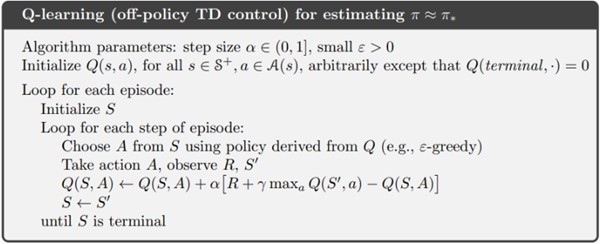

 The Q-learning pseudocode. Image courtesy of Reinforcement Learning: An
Introduction, p131, R. Sutton & A. Barto (2018)

In [6]:

def Q_learning(mode, epsilon = 0.15, alpha = 0.1, num_episodes = 500,
               gamma = 0.9, num_agents = 50):
    
    results = []
    results = []
    total = []
    env= Tetris(mode = mode)

    for j in range(num_agents):
            rewards = []
            lines_cleared = []
            states = states_fun()
            for i in range(num_episodes):
                state = env.reset()
                action = choose_action(env,epsilon,states, state)
                total_reward = 0

                while True:

                    next_state, reward, terminal = env.step(action)

                    if terminal:

                        states[state][action] += alpha * (reward + gamma * 1/7 - states[state][action])

                    else:
                        next_action = choose_action(env, epsilon, states, next_state)
                        states[state][action] += alpha * (reward + gamma * np.max(states[next_state]) - states[state][action])

                    action = next_action
                    state = next_state
                    total_reward += reward

                    if terminal :
                        rewards.append(total_reward)
                        lines_cleared.append(env.total_lines)
                        break
            results.append(rewards)
            total.append(lines_cleared)
    return states, results, total




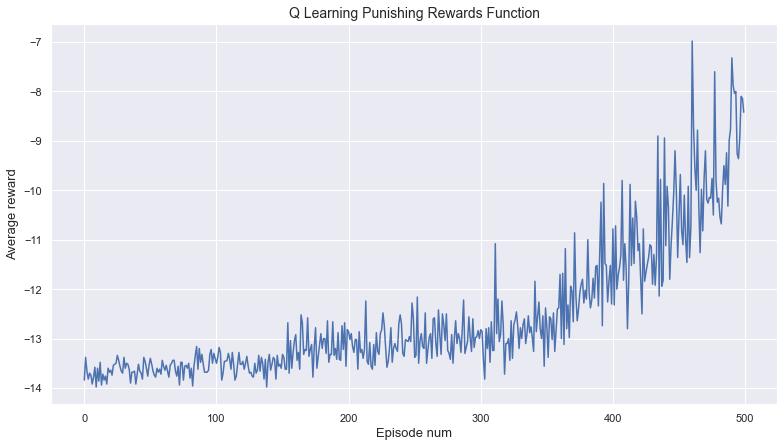

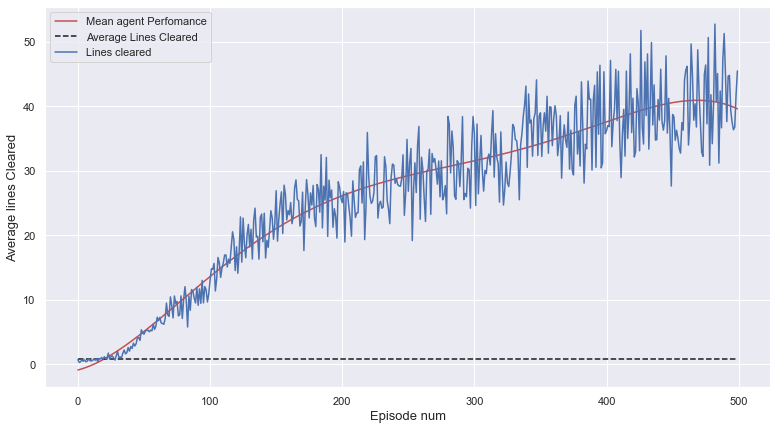

In [7]:
punish_q, punish_q_rewards, punish_q_lines = Q_learning(mode = 'punish')
plot(punish_q_rewards, punish_q_lines, 'Q Learning Punishing Rewards Function')

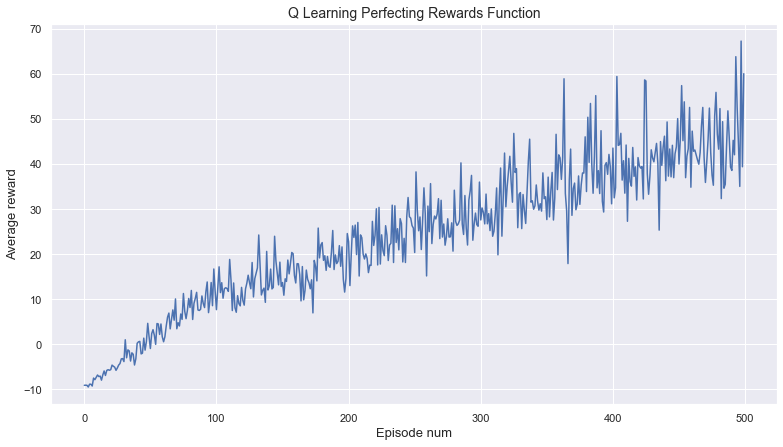

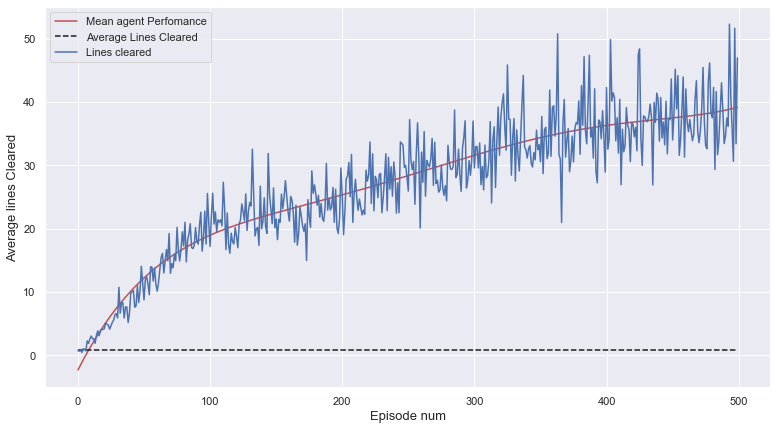

In [8]:
perfect_q, perfect_q_rewards, perfect_q_lines = Q_learning(mode = 'perfect')
plot(perfect_q_rewards, perfect_q_lines, 'Q Learning Perfecting Rewards Function')

## Sarsa

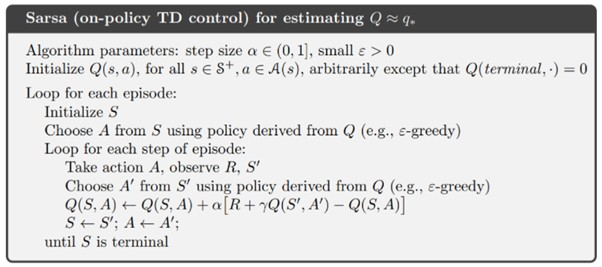
The SARSA pseudocode. Image courtesy of Reinforcement Learning: An Introduction, p130, R. Sutton & A. Barto (2018).

In [9]:
def SARSA(mode, epsilon = 0.15, alpha = 0.2, num_episodes = 500,
         gamma = 0.9, num_agents = 50):

    results = []
    env= Tetris(mode = mode)
    results = []
    total=[]
    for j in range(num_agents):
        rewards = []
        lines_cleared = []
        states = states_fun()
        for i in range(num_episodes):
            state = env.reset()
            action = choose_action(env,epsilon,states, state)
            total_reward = 0

            while True:

                next_state, reward, terminal = env.step(action)

                if terminal:

                    states[state][action] += alpha * (reward + gamma * 1/7 - states[state][action])

                else:
                    next_action = choose_action(env, epsilon, states, next_state)
                    states[state][action] += alpha * (reward + gamma * states[next_state][next_action] - states[state][action])

                action = next_action
                state = next_state
                total_reward += reward

                if terminal :
                    rewards.append(total_reward)
                    lines_cleared.append(env.total_lines)
                    break
        results.append(rewards)
        total.append(lines_cleared)
        
        return states, results, total
        




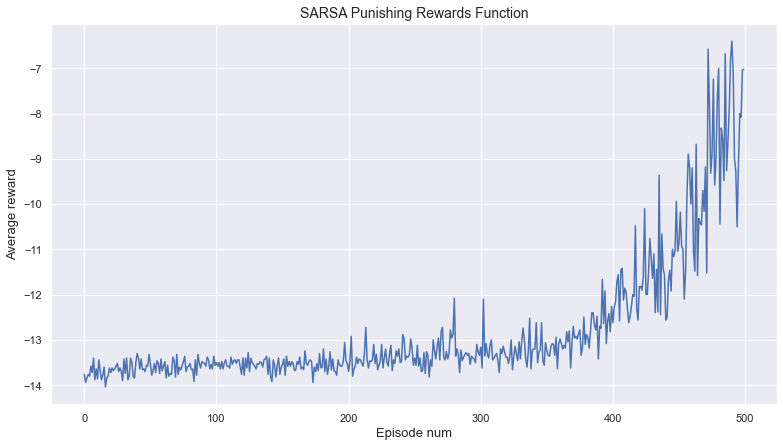

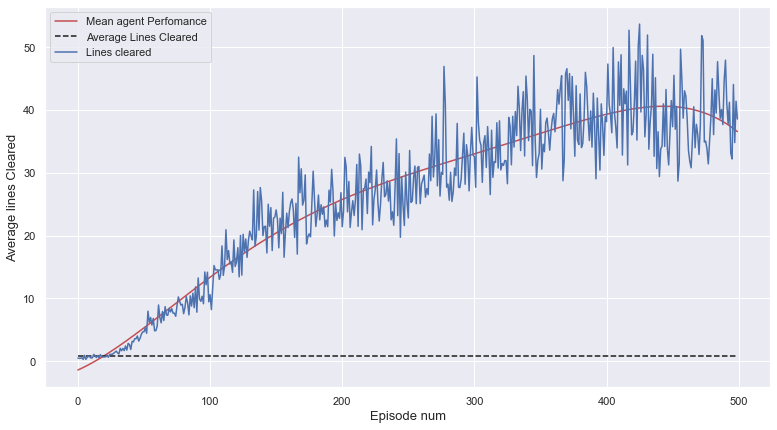

In [10]:
punish_s, punish_s_rewards, punish_s_lines = Q_learning(mode = 'punish')
plot(punish_s_rewards, punish_s_lines, 'SARSA Punishing Rewards Function')

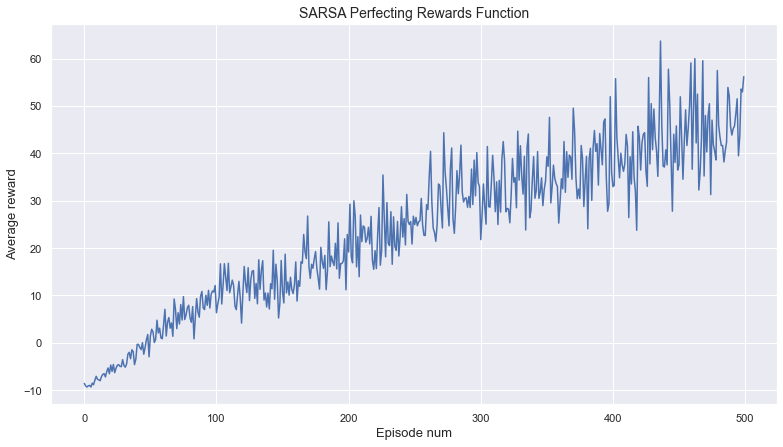

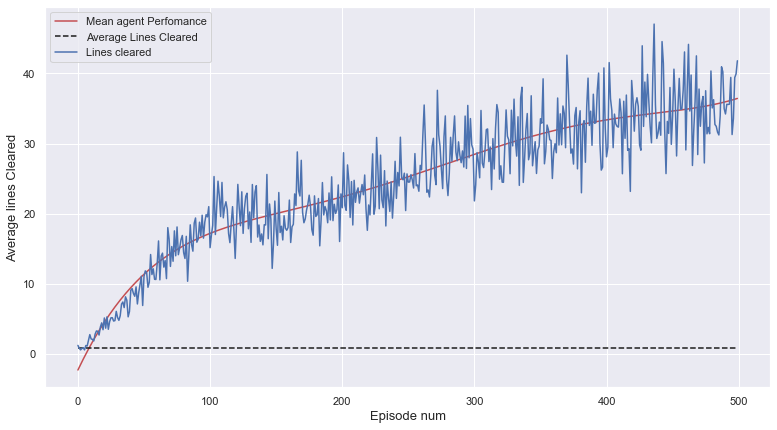

In [11]:
perfect_s, perfect_s_rewards, perfect_s_lines = Q_learning(mode = 'perfect')
plot(perfect_s_rewards, perfect_s_lines, 'SARSA Perfecting Rewards Function')

In [12]:
# Visualize the Agents for the first 50 moves

def visual(algo):

    env = Tetris()
    epsilon = 0
    alpha = 0.2
    num_episodes = 500
    gamma = 0.9
    num_agents = 1
    actions = [i for i in range(7)]
    for i in range(1):
        state = env.reset()
        for i in range(50):

            action = choose_action(env,epsilon,algo, state)

            state,reward,terminal = env.step(action,render = True)
            sleep(0.5)

            if terminal:
                break

    cv2.destroyAllWindows()
    
    return

#Choose one of the 4 - punish_q, punish_s, perfect_q, perfect_s
visual(punish_q)